# SSD 
Nick McKillip

In [1]:
import os
import collections
from distutils.version import LooseVersion
import torch, torchvision, torchtext
from torch import nn, cuda, backends, FloatTensor, LongTensor, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
from pathlib import Path
from matplotlib import pyplot as plt, rcParams, animation, patches, patheffects
import PIL, os, numpy as np, math, collections, threading, json, bcolz, random, scipy, cv2
import concurrent.futures
import pandas as pd
import torch
import pdb
from PIL import Image

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from IPython.core.debugger import set_trace

In [3]:
sz = 224

In [4]:
def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: rfes = np.repeat(res[...,None],3,2)
        #return res
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [5]:
PATH = Path('data/pascal')

In [6]:
trn_j = json.load((PATH /'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

In [7]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

## Load the annotations into a dictionary

In [9]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([float(bb[1]), float(bb[0]), float(bb[3]+bb[1]-1), float(bb[2]+bb[0]-1)])
            trn_anno[fns[o[IMG_ID]]].append((bb,o[CAT_ID]))
    return trn_anno

anno = get_trn_anno()

In [10]:
l = list(anno.items())

In [12]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, sz, 8))
    ax.set_yticks(np.linspace(0, sz, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [13]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], id2cat[c], sz=16)

In [14]:
def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if isinstance(v, torch.cuda.HalfTensor): v=v.float()
    return v.cpu().numpy()

## Display the image with colored annotations

In [15]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*sz).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [16]:
id2cat = list(cats.values())

## Build The Model

Conv Group Countains a series of a convolutional layer, followed by relu, batchnorm then dropout

In [17]:
model=resnet50(pretrained = True)


In [18]:
class ConvGroup(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, (3,3), stride=stride, padding =1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    
    def forward(self,x): return self.drop(self.bn(F.relu(self.conv(x))))

    

In [19]:
def flatten(x,k):
    bs, nf, _, _ = x.shape
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

## Output's class and bounding box predictions

In [20]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv2d(nin, len(id2cat)*k, 3, padding =1) # classification activations
        self.conv2 = nn.Conv2d(nin, 4*k, 3, padding =1) # bounding box activations
        self.conv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten(self.conv1(x), self.k), flatten(self.conv2(x), self.k)]
        

In [21]:
drop = 0.4
k = 9 # number of anchor boxes per grid cell

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = ConvGroup(2048,512, stride=1, drop=drop)
        self.sconv1 = ConvGroup(512, 256, drop=drop)
        self.sconv2 = ConvGroup(256,256, drop=drop)
        self.sconv3 = ConvGroup(256,256, drop=drop)        
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
    
    def forward(self,x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        c1, l1 = self.out1(x)
        x = self.sconv2(x)
        c2, l2 = self.out2(x)
        x = self.sconv3(x)
        c3, l3 = self.out3(x)
        
        return [torch.cat([c1,c2,c3], dim=1),
                torch.cat([l1,l2,l3], dim=1)]
  

In [22]:
head = SSD_Head(k, -3)


In [23]:
class FineTuneModel(nn.Module):
    def __init__(self, original_model, custom_head):
        super().__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.custom_head = custom_head
    
    def forward(self, x):
        x = self.features(x)

        x = self.custom_head(x)
        
        return x


In [24]:
SSD = FineTuneModel(model, head)

## Data Augmentation
I'm only using horizonal flips

In [25]:
def random_horizontal_flip(im, bbs):
    if np.random.random() < 0.5:
        im = im[:,:,::-1]
        bbs = np.reshape(bbs,(-1,4))
        non_zero = np.sum(bbs, axis=1).nonzero()
        bbs[non_zero,1::2] = sz - bbs[non_zero,3::-2]
        bbs = bbs.flatten()
    return im, bbs

In [26]:
class PascalDataset(Dataset):
    
    def __init__(self, fn, mc, bbox, image_dir, train):
        self.fn = fn
        self.mc = mc
        self.bbox = bbox
        self.image_dir = image_dir
        self.train=train
    
    def __len__(self):
        return len(self.fn)

    def __getitem__(self, i):
        img_path = os.path.join(self.image_dir, self.fn[i])
        img = open_image(img_path)
        img = np.transpose(img,(2,0,1))
        mc= self.mc[i]
        bbox = self.bbox[i]
        if self.train == True:
            img, bbox = random_horizontal_flip(img, bbox)
        img = torch.tensor(img.copy())
        return (img, [bbox, mc])

In [27]:
fn = np.array(list(anno.keys()))

In [28]:
mbb = np.array([np.concatenate([p[0] for p in a]) for a in list(anno.values())])

In [30]:
def resize_imgs_bbs(fnames, bboxs, targ, path, new_path):
    new_bbs = []
    for index, (fname, bbox) in enumerate(zip(fnames, bboxs)):
        new_bbox = resize_img_bbox(fname, bbox, targ, path, new_path)
        new_bbs.append(new_bbox)
    return os.path.join(path, new_path, str(targ)), new_bbs
            

In [31]:
def resize_img_bbox(fname, bbox, targ, path, new_path):
    dest = os.path.join(path, new_path, str(targ), fname)
    im = Image.open(os.path.join(path, fname)).convert('RGB')
    x_, y_ = im.size
    x_scale = targ[0]/x_
    y_scale = targ[1]/y_
    os.makedirs(os.path.split(dest)[0], exist_ok=True)
    im.resize(targ, Image.LINEAR).save(dest)
    new_bbox = [p*y_scale if i%2 == 0 else p*x_scale for i, p in enumerate(bbox)]
    return np.array(new_bbox)

In [32]:
IMG_PATH_SZ = IMG_PATH/str(sz)

In [33]:
IMG_PATH_SZ, mbb = resize_imgs_bbs(list(fns.values()), mbb, (sz,sz), IMG_PATH, 'Resized')

In [35]:
mc = np.array([np.array([p[1]-1 for p in a]) for a in list(anno.values())])

In [36]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [37]:
def hw2corners(center, hw):
    return torch.cat([center-hw/2, center + hw/2], dim=1)

In [38]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]

In [39]:
anchor_scales = [(anc_z*i, anc_z*j) for anc_z in anc_zooms for(i,j) in anc_ratios]
k = len(anchor_scales)

In [40]:
anchor_scales

[(0.7, 0.7),
 (0.7, 0.35),
 (0.35, 0.7),
 (1.0, 1.0),
 (1.0, 0.5),
 (0.5, 1.0),
 (1.3, 1.3),
 (1.3, 0.65),
 (0.65, 1.3)]

In [41]:
anc_offsets = [1/(o*2) for o in anc_grids]

In [42]:
anc_offsets

[0.125, 0.25, 0.5]

In [43]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)for ao, ag, in zip(anc_offsets, anc_grids)])

anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)for ao, ag, in zip(anc_offsets, anc_grids)]); anc_y

anc_cntrs = np.repeat(np.stack([anc_x, anc_y], axis = 1), k,axis=0);  anc_cntrs

array([[0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.125],
       [0.375, 0.125],
       [0.375, 0.125],
       [0.375, 0.125],
       [0.375, 0.125],
       [0.375, 0.125],
       [0.3

In [44]:
anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625,
       0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875, 0.25 , 0.25 ,
       0.75 , 0.75 , 0.5  ])

In [45]:
grid_sizes = torch.tensor(np.concatenate([np.array([1/ag for i in range(ag*ag) for o,p in anchor_scales]) for ag in anc_grids]),
                         requires_grad=False).unsqueeze(1).float()

In [46]:
anc_sizes = np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales]) for ag in anc_grids])

In [48]:
grid_sizes.shape

torch.Size([189, 1])

In [49]:
anchors = torch.tensor(np.concatenate([anc_cntrs, anc_sizes], axis=1), requires_grad=False).float()

In [50]:
anchors

tensor([[0.1250, 0.1250, 0.1750, 0.1750],
        [0.1250, 0.1250, 0.1750, 0.0875],
        [0.1250, 0.1250, 0.0875, 0.1750],
        [0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.2500, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.2500],
        [0.1250, 0.1250, 0.3250, 0.3250],
        [0.1250, 0.1250, 0.3250, 0.1625],
        [0.1250, 0.1250, 0.1625, 0.3250],
        [0.1250, 0.3750, 0.1750, 0.1750],
        [0.1250, 0.3750, 0.1750, 0.0875],
        [0.1250, 0.3750, 0.0875, 0.1750],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.1250],
        [0.1250, 0.3750, 0.1250, 0.2500],
        [0.1250, 0.3750, 0.3250, 0.3250],
        [0.1250, 0.3750, 0.3250, 0.1625],
        [0.1250, 0.3750, 0.1625, 0.3250],
        [0.1250, 0.6250, 0.1750, 0.1750],
        [0.1250, 0.6250, 0.1750, 0.0875],
        [0.1250, 0.6250, 0.0875, 0.1750],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.1250],
        [0.1250, 0.6250, 0.1250, 0

In [51]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [52]:
def activation_to_bounding_box(actn, anchors):
    actn = torch.tanh(actn)
    actn_centers = (actn[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = actn[:,2:]/2 + 1 * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [53]:
def resize_img_bbox(fname, bbox, targ, path, new_path):
    dest = os.path.join(path, new_path, str(targ), fname)
    if os.path.exists(dest): return dest
    im = Image.open(os.path.join(path, fname)).convert('RGB')
    x_ = im.shape[1]
    y_ = im.shape[0]
    x_scale = targ/x_
    y_scale = targ/y_
    os.makedirs(os.path.split(dest)[0], exist_ok=True)
    im.resize(targ, Image.LINEAR).save(dest)
    bbox = np.array([bbox[0]*x_scale, bbox[1]*y_scale, bbox[2]*x_scale, bbox[3]*y_scale])
    return bbox
    

In [54]:
def resize_img(fname, targ, path, new_path):
    dest = os.path.join(path, new_path, str(targ), fname)
    if os.path.exists(dest): return dest
    im = Image.open(os.path.join(path, fname)).convert('RGB')
    os.makedirs(os.path.split(dest)[0], exist_ok=True)
    im.resize(targ, Image.LINEAR).save(dest)
    return dest

In [55]:
def resize_imgs(fnames, targ, path, new_path):
    if not os.path.exists(os.path.join(path, new_path, str(targ), fnames[0])):
        with concurrent.futures.ThreadPoolExecutor(max_workers = 4) as e:
            ims = e.map(lambda x: resize_img(x, targ, path, new_path), fnames)
    return os.path.join(path, new_path, str(targ))
            

In [57]:
mc_max_len = max([len(l) for l in mc]); mc_max_len

19

In [59]:
mbb_max_len = max([len(l) for l in mbb]); mbb_max_len

76

In [60]:
pad_mc = []
for l in mc:
    for i in range(mc_max_len-len(l)):
        l = list(l)
        l.insert(0, 0)
    pad_mc.append(l)

pad_mc = np.array(pad_mc)

In [61]:
pad_mbb = []
for l in mbb:
    for i in range(mbb_max_len-len(l)):
        l = list(l)
        l.insert(0, 0)
    pad_mbb.append(l)
    
pad_mbb = np.array(pad_mbb)

In [62]:
pad_mbb

array([[  0.        ,   0.        ,   0.        , ...,  69.44      ,
        180.94894895, 156.8       ],
       [  0.        ,   0.        ,   0.        , ...,  41.53333333,
        206.15384615, 187.6       ],
       [  0.        ,   0.        ,   0.        , ..., 150.22754491,
        217.28      , 223.32934132],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 104.832     ,
         94.37866667, 124.544     ],
       [  0.        ,   0.        ,   0.        , ...,  85.568     ,
        111.104     , 147.392     ],
       [  0.        ,   0.        ,   0.        , ...,  30.464     ,
        206.03208556, 175.168     ]])

In [63]:
pad_mbb.shape

(2501, 76)

In [64]:
def get_trn_cv_idxs(n, pct=0.1):
    n_val = int(pct*n)
    idxs = np.random.permutation(n)
    return idxs[:n_val], idxs[n_val:]


val_idxs, trn_idxs = get_trn_cv_idxs(len(fns))

In [65]:
trn_fn = fn[trn_idxs]; trn_pad_mc = pad_mc[trn_idxs]; trn_pad_mbb = pad_mbb[trn_idxs];

In [66]:
val_fn = fn[val_idxs]; val_pad_mc = pad_mc[val_idxs]; val_pad_mbb = pad_mbb[val_idxs];

In [67]:
trn_pad_mbb

array([[  0.        ,   0.        ,   0.        , ...,  46.144     ,
        216.6006006 , 168.448     ],
       [  0.        ,   0.        ,   0.        , ...,  22.10133333,
        190.4       , 193.536     ],
       [  0.        ,   0.        ,   0.        , ...,  75.712     ,
        181.10638298, 172.928     ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  76.608     ,
        178.00533333, 124.096     ],
       [  0.        ,   0.        ,   0.        , ...,  28.        ,
        184.128     , 104.41666667],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        178.60266667,  14.336     ]])

In [68]:
trn_data = PascalDataset(trn_fn, trn_pad_mc, trn_pad_mbb, IMG_PATH_SZ, train = True)
val_data = PascalDataset(val_fn, val_pad_mc, val_pad_mbb, IMG_PATH_SZ, train = False)

In [69]:
trn_loader = DataLoader(trn_data, batch_size=16,  shuffle = True)
val_loader = DataLoader(val_data, batch_size=16, shuffle = True)

In [71]:
def intersect(box1, box2):
    max_xy = torch.min(box1[:, None, 2:], box2[None, :, 2:])
    min_xy = torch.max(box1[:, None, :2], box2[None, :, :2])
    inter = torch.clamp(max_xy - min_xy, min=0)
    return inter[:,:,0] * inter[:,:,1]

def box_sz(box):
    return (box[:,2]-box[:,0])*(box[:,3]-box[:,1])


def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a)[:,None] + box_sz(box_b)[None,:] - inter
    return inter/union

In [72]:
def one_hot_embedding(labels, num_classes):
    y = torch.eye(num_classes)
    return y[labels.long()]

In [73]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def get_weight(self,x,t):
        return None
    
    def forward(self, pred, targ):
        targ = one_hot_embedding(targ, self.num_classes+1)
        targ = torch.tensor(targ[:,:-1])
        w = self.get_weight(pred,targ)
        return F.binary_cross_entropy_with_logits(pred,targ, w, size_average=False)/self.num_classes

In [74]:
class FocalLoss(BCE_Loss):
    def get_weight(self, x,t):
        alpha, gamma = 0.25, 2
        p = x.sigmoid()
        pt = p*t + (1-t)*(1-p)
        alpha = alpha*t + (1-alpha)*(1-t)
        weight = alpha*(1-pt).pow(gamma)
    

In [75]:
focal_loss = FocalLoss(len(id2cat))

In [76]:
# removes 0 padding from the front of the targets
def get_non_zero(bbox, classes):
    bbox = bbox.view(-1,4)
    bbox = (bbox.float())/sz
    non_zero_index = (torch.sum(bbox, dim=1)!=0).nonzero()[:,0]
    return bbox[non_zero_index], classes[non_zero_index]



def actn_to_bb(actn, anchors):
    actn = torch.tanh(actn)
    centers = (actn[:,:2]/2 * grid_sizes) + anchors[:,:2]
    hw = (actn[:,2:]/2 + 1) * anchors[:,2:]
    return hw2corners(centers, hw)


# Input overlaps shape(objects, anchor_boxes) output anchor boxes max overlaps of shape(achor_boxes) and which object it max overlaps with also shape(anchor_boxes)
def map_to_ground_truth(overlaps):
    _, max_index = overlaps.max(1) # get the anchor box that the object has max overlaps with
    gt_overlap, gt_index = overlaps.max(0) # find the ground truth for what object the grid cell's map to, note
    gt_overlap[max_index] = 1 # manually ensure that that at least on anchor box has overlap > .4
    return gt_overlap, gt_index

def ssd_1_loss(clas_pred, bbox_pred_actvn, bbox, clas):
    bbox, clas = get_non_zero(bbox, clas)
    bbox_pred = actn_to_bb(bbox_pred_actvn, anchors)
    overlaps = jaccard(bbox.float().data, anchor_cnr.float().data)
    gt_overlap, gt_index = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_index] #from what object number it is in the picture to what class is in the picture
    pos = gt_overlap > 0.4 # get overlaps > .4
    pos_idx = torch.nonzero(pos)[:,0] ## index's to keep
    gt_clas[1-pos] = len(id2cat) # all below .4 to background
    gt_bbox = bbox[gt_index]
    loc_loss = ((bbox_pred[pos_idx] - gt_bbox[pos_idx]).abs()).mean() # difference in preds at non-bg idx's from the gt
    class_loss = focal_loss(clas_pred, gt_clas)
    return loc_loss, class_loss
    
    
    
def ssd_loss(pred, targ):
    total_bb_loss, total_class_loss = 0, 0
    # loop through the training examples and total the loss
    targ[0] = targ[0].float()
    targ[1] = targ[1].float()
    for clas_pred, bbox_pred, bbox, clas in zip(*pred, *targ):
        bb_loss, class_loss = ssd_1_loss(clas_pred,bbox_pred, bbox, clas)
        total_bb_loss +=  (1/30) * bb_loss
        total_class_loss += class_loss
        
    return total_bb_loss+total_class_loss

In [77]:
def test_loader():
    batch = next(iter(trn_loader))
    im = batch[0][0]
    im = im.permute(1,2,0)
    bbs = batch[1][0][0]
    classes = batch[1][1][0]
    bbs, classes = get_non_zero(bbs, classes)
    bbs = to_np(bbs)
    classes = to_np(classes)
    ann = zip(sz*bbs, classes)
    draw_im(im, ann)

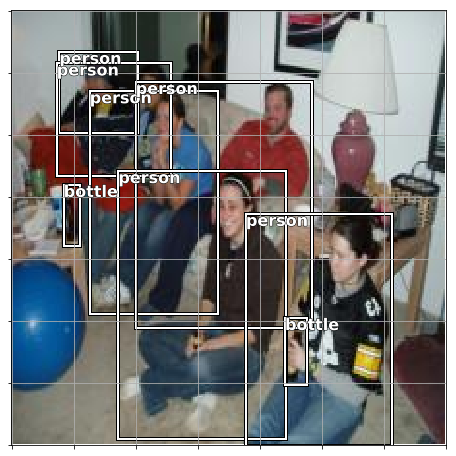

In [78]:
test_loader()

## Freezing the weights of the resnet layers

In [79]:
blocks = []

In [80]:
for index, child in enumerate(SSD.children()):
    if index == 0:
        for i, block in enumerate(child):
            blocks.append(block)
    elif index == 1:
        blocks.append(child)

In [81]:
for block in blocks[:-1]:
    block.requires_grad = False

## Training Loop

In [82]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

In [83]:
def training_loop(lrs):
    trn_losses = []
    val_losses = []
    for i in range(len(lrs)):
        print()
        print("Epoch",i+1)
        print()

        optimizer = optim.Adam(SSD.parameters(), lr = lrs[i])
        for trn_data, val_data in zip(trn_loader, val_loader):
            images, labels = trn_data
            optimizer.zero_grad()
            outputs = SSD(images)
            loss = ssd_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            trn_loss = loss.item()
            trn_losses.append(trn_loss)
            if len(trn_losses)>10:
                trn_losses.pop(0)
            val_images, val_labels = val_data
            outputs = SSD(val_images)
            loss = ssd_loss(outputs, val_labels) 
            val_loss = loss.item() 
            val_losses.append(val_loss)
            if len(val_losses)>10:
                val_losses.pop(0)
            print("Train Losses Avg:", sum(trn_losses)/len(trn_losses), "Validation Loss Avg:", sum(val_losses)/len(val_losses))



In [84]:
training_loop(lrs)


Epoch 1



/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Losses Avg: 168.4653778076172 Validation Loss Avg: 189.1138916015625
Train Losses Avg: 185.2661895751953 Validation Loss Avg: 151.2317771911621
Train Losses Avg: 160.72203572591147 Validation Loss Avg: 124.87364959716797
Train Losses Avg: 140.17535591125488 Validation Loss Avg: 104.34205055236816
Train Losses Avg: 122.67483215332031 Validation Loss Avg: 92.93749313354492
Train Losses Avg: 109.78927866617839 Validation Loss Avg: 82.83654530843098
Train Losses Avg: 99.11228452410016 Validation Loss Avg: 75.99779020036969
Train Losses Avg: 91.83424377441406 Validation Loss Avg: 72.2478346824646
Train Losses Avg: 86.1634898715549 Validation Loss Avg: 68.28200827704535
Train Losses Avg: 80.69023056030274 Validation Loss Avg: 64.97777671813965
Train Losses Avg: 67.04273529052735 Validation Loss Avg: 50.09906196594238
Train Losses Avg: 53.32641677856445 Validation Loss Avg: 43.87802391052246
Train Losses Avg: 46.914649200439456 Validation Loss Avg: 40.58529930114746
Train Losses Avg: 43

KeyboardInterrupt: 

In [ ]:
# rescale bb vs class loss
def ssd_loss(pred, targ):
    total_bb_loss, total_class_loss = 0, 0
    # loop through the training examples and total the loss
    targ[0] = targ[0].float()
    targ[1] = targ[1].float()
    for clas_pred, bbox_pred, bbox, clas in zip(*pred, *targ):
        bb_loss, class_loss = ssd_1_loss(clas_pred,bbox_pred, bbox, clas)
        total_bb_loss += 5 *  bb_loss
        total_class_loss += class_loss
        
    return total_bb_loss+total_class_loss

In [100]:
training_loop([1e-3, 1e-4,])


Epoch 1



/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Losses Avg: 43.54804992675781 Validation Loss Avg: 53.39921569824219
Train Losses Avg: 46.07666778564453 Validation Loss Avg: 52.255123138427734
Train Losses Avg: 45.18191782633463 Validation Loss Avg: 49.312255859375
Train Losses Avg: 47.07292366027832 Validation Loss Avg: 49.82413864135742
Train Losses Avg: 47.54768447875976 Validation Loss Avg: 50.268801879882815
Train Losses Avg: 46.5728956858317 Validation Loss Avg: 48.309942881266274
Train Losses Avg: 47.90985924857004 Validation Loss Avg: 47.023109436035156
Train Losses Avg: 48.01702260971069 Validation Loss Avg: 47.37404203414917
Train Losses Avg: 48.064327239990234 Validation Loss Avg: 46.70724656846788
Train Losses Avg: 47.48587265014648 Validation Loss Avg: 46.139387893676755
Train Losses Avg: 48.22643127441406 Validation Loss Avg: 45.789313888549806
Train Losses Avg: 48.78342819213867 Validation Loss Avg: 45.36747703552246
Train Losses Avg: 49.417547607421874 Validation Loss Avg: 45.37771377563477
Train Losses Avg: 48

KeyboardInterrupt: 

In [85]:
torch.save(SSD.state_dict(), 'ssd1.pt')

In [86]:
"""for index, block in enumerate(blocks[::-1]):
    if index <=2:
        block.requires_grad=True"""

'for index, block in enumerate(blocks[::-1]):\n    if index <=2:\n        block.requires_grad=True'

In [87]:
# Original author: Francisco Massa:
# https://github.com/fmassa/object-detection.torch
# Ported to PyTorch by Max deGroot (02/01/2017)
def nms(boxes, scores, overlap=0.5, top_k=200):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [101]:
def make_preds():
    batch = next(iter(val_loader))
    images = batch[0]
    ann = batch[1]
    preds = SSD(images)
    return images, preds, anno

In [102]:
def show_pred(images, preds, i):
    im = images[i]
    im = im.permute(1,2,0)
    clas = preds[0][i]
    bboxs = preds[1][i]
    bboxs = actn_to_bb(bboxs, anchors)
    class_prob, class_ids = clas.max(1)
    class_prob = class_prob.sigmoid()
    
    out_scores, out_bboxs, out_classes = [],[],[]
    conf_scores = clas.sigmoid().t().data
    for clas in range(len(conf_scores)-1):
        class_mask = conf_scores[clas] > 0.15
        scores = conf_scores[clas][class_mask]
        if class_mask.sum() == 0: continue
        bbox = bboxs[class_mask]
        ids, count = nms(bbox.data, scores, 0.4, 100)
        ids = ids[:count]
        out_scores.append(scores[ids])
        out_bboxs.append(bbox.data[ids])
        out_classes.append([clas]*count)
       
    if len(out_classes) > 0:
        out_classes = torch.tensor(np.concatenate(out_classes))
        out_scores = torch.cat(out_scores)
        out_bboxs = torch.cat(out_bboxs)
    
    
        fig, ax = plt.subplots(figsize=(8,8))
        torch_gt(ax, im, out_bboxs, out_classes, out_scores, 0.1)

In [103]:
images, preds, _= make_preds()

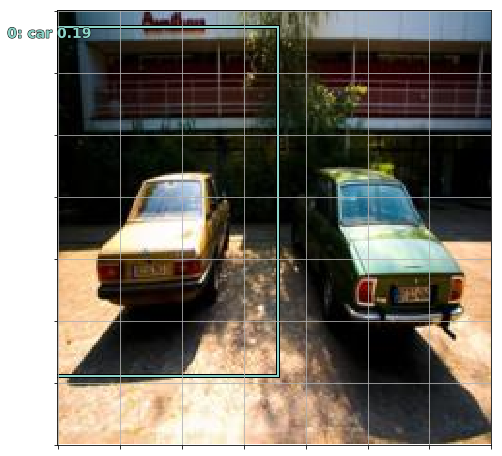

In [106]:
show_pred(images,preds, 1)
    


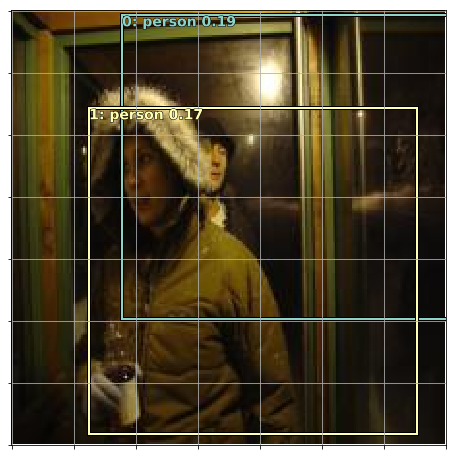

In [114]:
show_pred(images,preds, 9)